In [1]:
!pip3 install -q --upgrade --user git+https://github.com/pymc-devs/pymc4.git

# Hierarchical radon model

(c) 2019 Thomas Wiecki, Junpeng Lao

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm 
import pandas as pd
import tensorflow as tf
import arviz as az

data = pd.read_csv(pm.utils.get_data('radon.csv'))

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)

In [3]:
@pm.model
def hierarchical_model(data, county_idx):
    # Hyperpriors
    mu_a = yield pm.Normal(loc=0., scale=1, name='mu_alpha')
    sigma_a = yield pm.HalfCauchy(scale=1, name='sigma_alpha')
    mu_b = yield pm.Normal(loc=0., scale=1, name='mu_beta')
    sigma_b = yield pm.HalfCauchy(scale=1, name='sigma_beta')

    # Intercept for each county, distributed around group mean mu_a
    a = yield pm.Normal(loc=mu_a, scale=sigma_a, plate=len(data.county.unique()),
                        name='alpha')
    # Intercept for each county, distributed around group mean mu_a
    b = yield pm.Normal(loc=mu_b, scale=sigma_b, plate=len(data.county.unique()),
                        name='beta')

    # Model error
    eps = yield pm.HalfCauchy(scale=1, name='eps')

    # Expected value
    #radon_est = a[county_idx] + b[county_idx] * data.floor.values
    radon_est = tf.gather(a, county_idx) + tf.gather(
        b, county_idx) * data.floor.values

    # Data likelihood
    y_like = yield pm.Normal(loc=radon_est, scale=eps, observed=data.log_radon, name='y_like')

### Mass matrix adaptation
Essentially, we are doing a 2 window adaptation similar to Stan below: dual averaging for burn_in samples, and then normal sample for diagonal mass matrix estimation.

In [4]:
def sample(model, init_num_chains=50, num_samples=500, burn_in=500):
    init_num_chains = 50
    pm4_trace, _ = pm.inference.sampling.sample(
        model, num_chains=init_num_chains, num_samples=10, burn_in=10, step_size=1., xla=True)
    for i in range(3):
        step_size_ = []
        for _, x in pm4_trace.items():
            std = tf.math.reduce_std(x, axis=[0, 1])
            step_size_.append(
                std[tf.newaxis, ...] * tf.ones([init_num_chains] + std.shape, dtype=std.dtype))
        pm4_trace, _ = pm.inference.sampling.sample(
            model, num_chains=init_num_chains, num_samples=10 + 10*i, burn_in=10 + 10*i,
            step_size=step_size_, xla=True)
        
    num_chains = 5
    step_size_ = []
    for _, x in pm4_trace.items():
        std = tf.math.reduce_std(x, axis=[0, 1])
        step_size_.append(
            std[tf.newaxis, ...] * tf.ones([num_chains]+std.shape, dtype=std.dtype))

    pm4_trace, sample_stat = pm.inference.sampling.sample(
        model, num_chains=num_chains, num_samples=num_samples, burn_in=burn_in,
        step_size=step_size_, xla=True)
    
    az_trace = pm.inference.utils.trace_to_arviz(pm4_trace, sample_stat)
    
    return az_trace

In [5]:
model = hierarchical_model(data, county_idx)
az_trace = sample(model)

In [6]:
np.mean(np.exp(az_trace.sample_stats['mean_tree_accept']), axis=1)

<xarray.DataArray 'mean_tree_accept' (chain: 5)>
array([0.8172503 , 0.8359025 , 0.8131493 , 0.83609784, 0.8024117 ],
      dtype=float32)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4

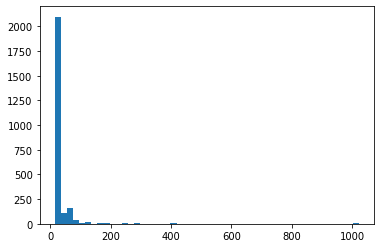

In [7]:
plt.hist(np.ravel(az_trace.sample_stats['tree_size']), 50);

In [8]:
az.summary(az_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
hierarchical_model/mu_alpha,1.488,0.050,1.393,1.584,0.001,0.001,1258.0,1257.0,1258.0,1791.0,1.00
hierarchical_model/mu_beta,-0.629,0.083,-0.786,-0.476,0.003,0.002,821.0,821.0,826.0,1442.0,1.00
hierarchical_model/alpha[0],1.192,0.255,0.749,1.688,0.005,0.004,2281.0,2281.0,2288.0,1693.0,1.00
hierarchical_model/alpha[1],0.989,0.098,0.814,1.181,0.002,0.001,3270.0,3200.0,3240.0,1858.0,1.00
hierarchical_model/alpha[2],1.492,0.271,1.006,2.035,0.006,0.004,2141.0,2090.0,2138.0,1626.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
hierarchical_model/beta[83],-0.640,0.326,-1.269,-0.053,0.005,0.004,3596.0,3031.0,3610.0,1742.0,1.00
hierarchical_model/beta[84],-0.629,0.376,-1.414,0.026,0.007,0.006,2575.0,1809.0,2543.0,1364.0,1.01
hierarchical_model/__log_sigma_alpha,-1.126,0.140,-1.385,-0.865,0.005,0.004,783.0,776.0,792.0,1311.0,1.00
hierarchical_model/__log_sigma_beta,-1.068,0.241,-1.513,-0.628,0.019,0.013,165.0,165.0,167.0,416.0,1.01


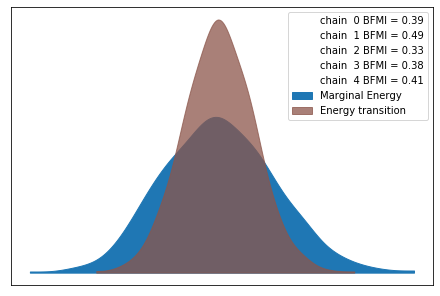

In [9]:
az.plot_energy(az_trace);

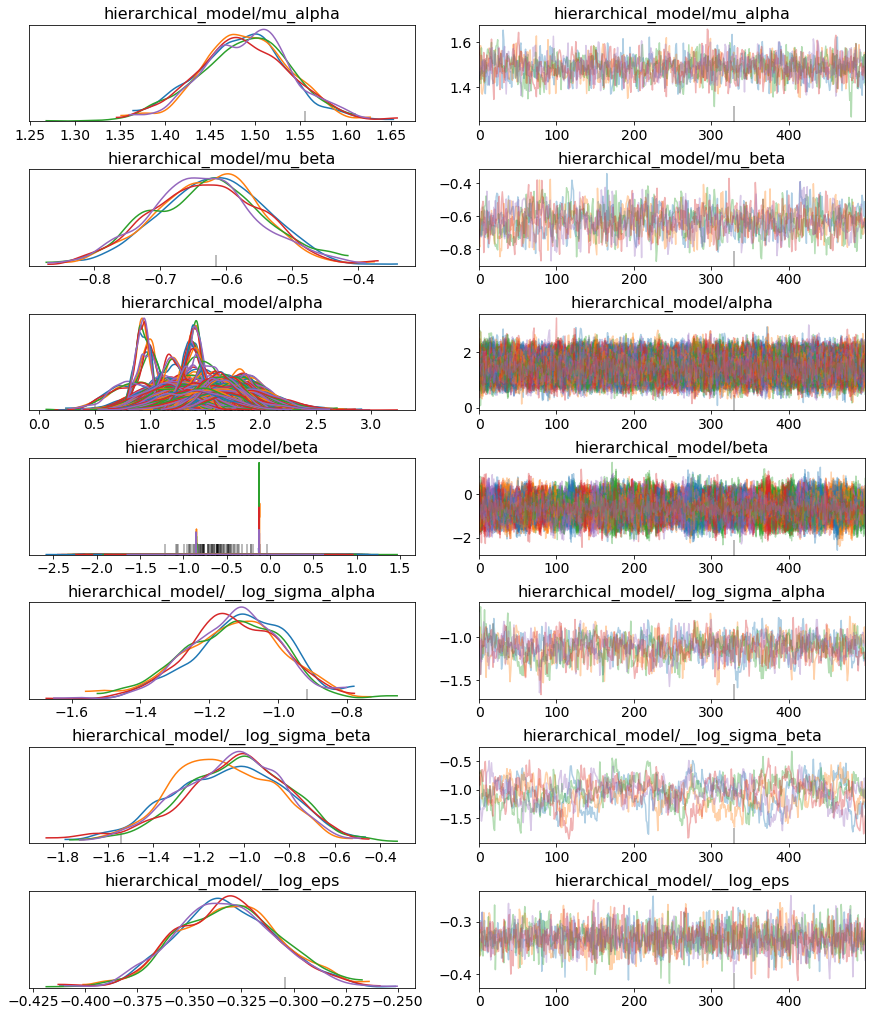

In [10]:
az.plot_trace(az_trace, compact=True);

## Models are just distributions

In [12]:
@pm.model
def Hierarchical(n, centered=True):
    mu = yield pm.Normal(loc=0., scale=1, name='mu')
    sigma = yield pm.HalfCauchy(scale=1, name='sigma')
    if centered:
        s = yield pm.Normal(loc=mu, scale=sigma, 
                            plate=n, name='s')
    else:
        offset = yield pm.Normal(loc=0, scale=1, 
                                 plate=n, name='offset')
        s = mu + sigma * offset
    return s
    
@pm.model
def hierarchical_model_nc(data, county_idx):
    n = len(data.county.unique())
    # TODO Use same name-syntax as with other RVs
    a = yield Hierarchical(n=n, centered=True, name='alpha')
    b = yield Hierarchical(n=n, centered=False, name='beta')

    # Model error
    eps = yield pm.HalfCauchy(scale=1, name='eps')

    # Expected value
    radon_est = tf.gather(a, county_idx) + tf.gather(
        b, county_idx) * data.floor.values

    # Data likelihood    
    y_like = yield pm.Normal(loc=radon_est, scale=eps, observed=data.log_radon, name='y_like')

In [13]:
model = hierarchical_model_nc(data, county_idx)
az_trace_nc = sample(model)

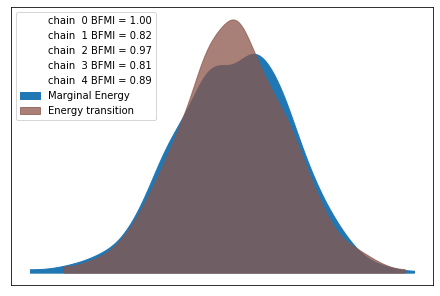

In [14]:
az.plot_energy(az_trace_nc);

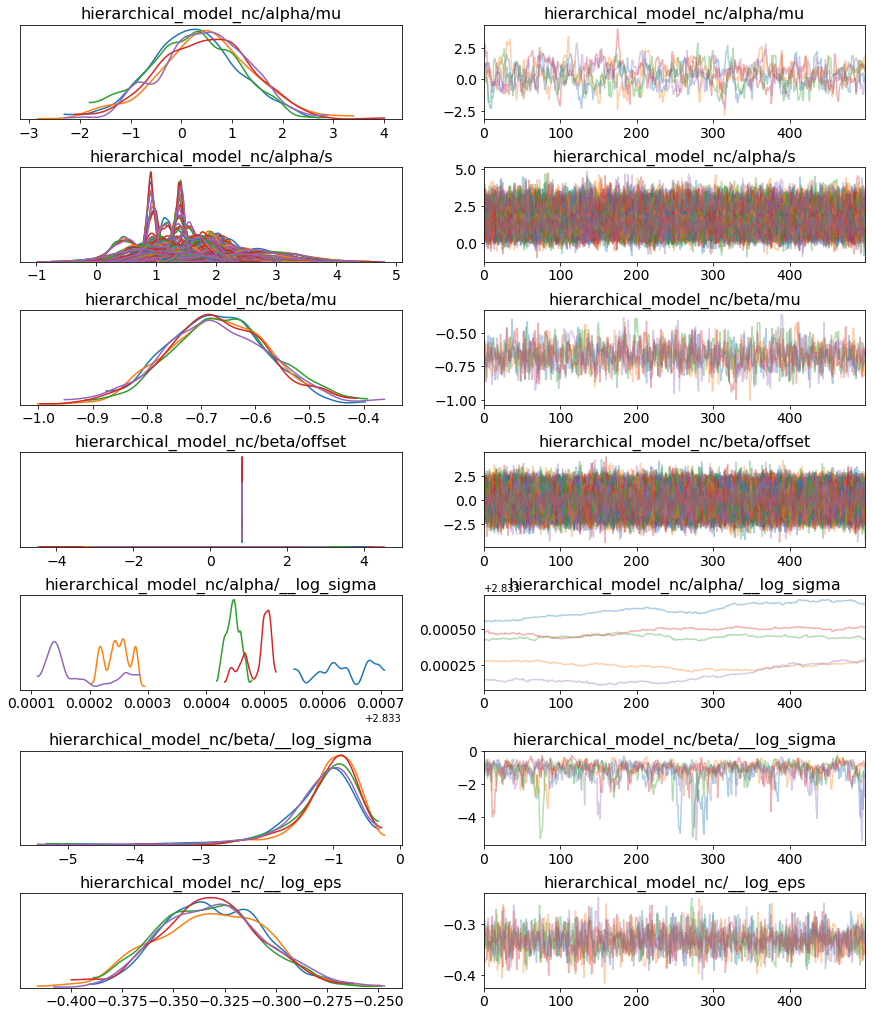

In [15]:
az.plot_trace(az_trace_nc, compact=True);